# 06. PyTorch Transfer Learning:

What is transfer learning?

Transfer learning involves taking the parameter of what one model has learned on another dataset and applying them to our own problem.

* Pretrained model = Foundation models

In [1]:
import torch
import torchvision

print(torch.__version__) # Want 1.12+
print(torchvision.__version__) # Want 0.13+

2.10.0+cu128
0.25.0+cu128


Now that we've got the versions of torch and torchvision we're after, let's import the code we've written in previous sections so that we don't have to write it all again.

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo; install it if it doesn't work
try:
    from torchinfo import summary
except:
    print('[INFO] Couldn\'t find torchinfo... installing it.')
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory; download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print('[INFO] Couldn\'t find going_modular scripts... downloading them from GitHub.')
    !git clone https://github.com/mrdbourke/python-deep-learning
    !mv pytorch-deep-learning/going_modular
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find going_modular scripts... downloading them from GitHub.


Cloning into 'python-deep-learning'...
remote: Repository not found.
fatal: repository 'https://github.com/mrdbourke/python-deep-learning/' not found
'mv' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


ModuleNotFoundError: No module named 'going_modular.going_modular'

In [2]:
from going_modular import data_setup, engine

c:\Users\Jake\Documents\Udemy_Courses\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set up device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Get Data:

We need our pizza, steak, and sushi data to build a transfer learning model on.

In [4]:
import os
import zipfile

from pathlib import Path

import requests

# Set up data path
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi' # Images from a subset of classes form the Food101 dataset

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f'{image_path} directory exists, skipping re-download.')
else:
    print(f'Did not find {image_path}, downloading it...')
    image_path.mkdir(parents = True, exist_ok = True)

    # Download pizza, steak, and sushi data
    with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
        request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
        print('Donwloading pizza, steak, and sushi data...')
        f.write(request.content)
    
    # Unzip pizza, steak, and sushi data
    with zipfile.ZipFile(data_path / 'pizza_steak_sushi', 'r') as zip_ref:
        print('Unzipping pizza, steak, sushi data...')
        zip_ref.extractall(image_path)
    
    # Remove .zip file
    os.remove(data_path / 'pizza_steak_sushi.zip')

data\pizza_steak_sushi directory exists, skipping re-download.


In [5]:
# Set up directory path
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets And DataLoaders:

Now that we've got some data, we want to turn it into PyTorch DataLoaders.

To do so, we can use `data_setup.py` and the `create_dataloaders()` function we made in 05. PyTorch Going Modular.

There's one thing we have to think about when loading: How to **transform** it?

And with `torchvision` 0.13+, there's two ways to do this:

1. Manually created transforms - You define what transforms you want your data to go through.
2. Automatically created transforms - The transforms for your data are defined by the model you'd like to use.

Important point: When using a pretrained model, it's important that the data (including your custom data) that you pass through it is **transgormed** in the same way that the data the model was trained on.

In [6]:
from going_modular import data_setup

### 2.1. Creating A Transform For `torchvision.models` (Manual Creation):

`torchvision.models` contains pretrained models (models ready for transfer learning) right within `torchvision`.

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then ormalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize.

In [7]:
from torchvision import transforms
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                 std = [0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224, 244)), # Resize image to 224, 244 (height x width)
    transforms.ToTensor(), # Get images into range [0, 1]
    normalize # Make sure the images have the same distribution as ImageNet (where our pretrained models have been trained)
])

In [8]:
from going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = manual_transforms,
                                                                               batch_size = 32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2283a96afd0>,
 ['pizza', 'steak', 'sushi'])

### 2.2. Creating A Transform For `torchvision.models` (Auto Creation):

As of `torchvision` v0.13+, there is now support for automatic data transform creation based on the pretrained model weights you're using.

In [9]:
import torchvision
torchvision.__version__

'0.25.0+cu128'

In [10]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = Best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [11]:
# Get the reansforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [12]:
# Create DataLoaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = auto_transforms,
                                                                               batch_size = 32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2283a97e8d0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting A Pretrained Model:

There are various places to get a pretrained model, such as:
1. PyTorch domain libraries
2. Libraries like `timm` (torch image models)
3. HuggingFace Hub (for plenty of different models)
4. Paperswithcode (for models across different problem spaces/domains)

### 3.1. Which Pretrained Model Should You Use?

*Experiment, experiment, experiment!*

The whole idea of transfer learning: take an already well-performing model from a problem space similar to your own and then customize to your own problem.

Three things to consider:
1. Speed - How fast does it need to run?
2. Size - How big is the model?
3. Performance - How well does it go on your chosen problem (e.g. How well does it classify food images for FoodVision Mini?)

Where does the model live?

Is it on a device? (like a self-driving car)

Or does it live on a server?

Looking at https://pytorch.org/vision/main/models.html#table-of-all-available-classification-weights

Which model should we choose?

For our case (deploying FoodVision Mini on a mobile device), it looks like EffNetB0 is one of our best options in terms of perfromance vs size.

However, in light of The Bitter Lesson, if we had infinite compute, we'd likely pick the biggest model + most parameters + most general we could - http://www.incompleteideas.net/IncIdeas/BitterLesson.html

### 3.2. Setting Up A Pretrained Model:

Want to create an instance of a pretrained EffNetB0 - https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.EfficientNet_B0_Weights

In [13]:
# OLD method of creating a pretrained model (prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained = True)

# New method of creating a pretrained model (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # ".DEFAULT" = Best available weights
model = torchvision.models.efficientnet_b0(weights = weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [14]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [15]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [16]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3. Getting A Summary Of Our Model With `torchinfo.summary()`:

In [17]:
# Print with torchinfo
from torchinfo import summary

summary(model = model,
        input_size = (1, 3, 224, 224), # Example of [batch_size, color_channels, height, width]
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4. Freezing The Base Model And Changing The Output Layer To Suit Our Needs:

With a feature extractor model, typically, you will "freeze" the base layers of a pretrained/foundation model andupdate the output layers to suit your own problem.

In [18]:
# Freeze all of the base layers in EffNetB0
for param in model.features.parameters():
    # print(param)
    param.requires_grad = False

In [19]:
# Update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p = 0.2, inplace = True),
    nn.Linear(in_features = 1280, # Feature vector coming in
              out_features = len(class_names)).to(device) # How many classes do we have?
)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [20]:
summary(model = model,
        input_size = (1, 3, 224, 224), # Example of [batch_size, color_channels, height, width]
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train Model:

In [21]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
# Import train function
from going_modular import engine

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Set up training and save the results
results = engine.train(model = model,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 5,
                       device = device)

# End the timer and print out how long it took
end_time = timer()
print(f'[INFO] Total training time: {end_time - start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

## 5. Evaluate Model By Plotting Loss Curves:

helper_functions.py already downloaded, skipping download...


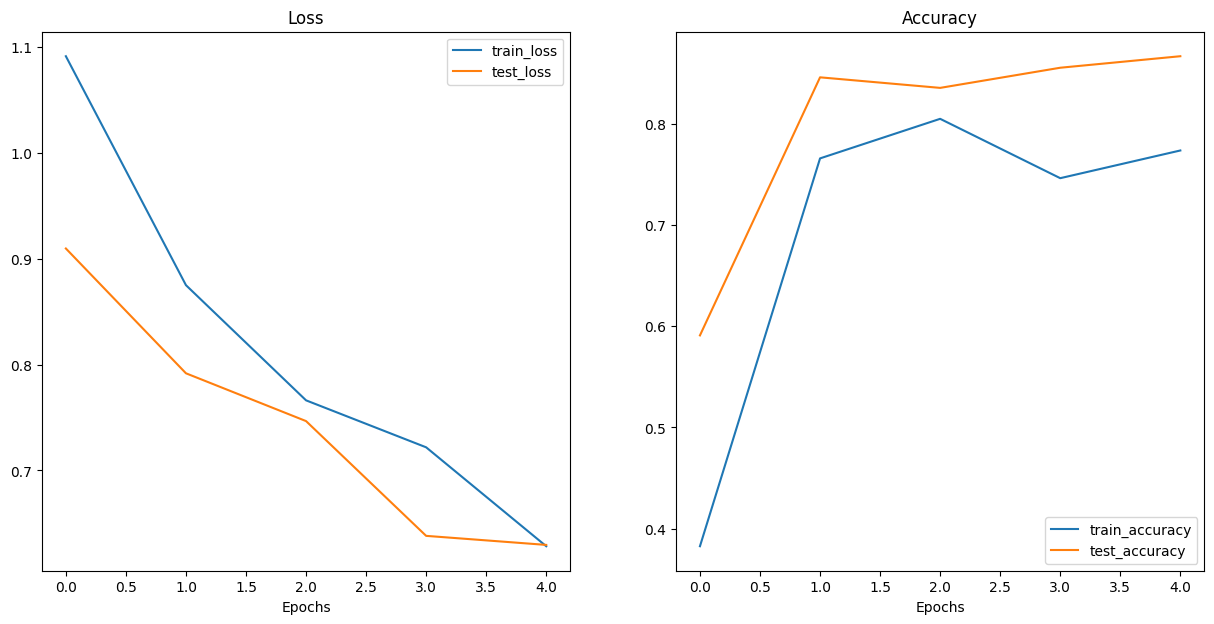

In [ ]:
try:
    from helper_functions import plot_loss_curves
    print('helper_functions.py already downloaded, skipping download...')
except:
    print('[INFO] Couldn\'t find helper_functions.py, downloading...')
    with open('helper_functions.py', 'wb') as f:
        import requests
        request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

What do our loss curves look like in terms of the ideal loss curve?

See here for more: https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like